# 1. Autoencoder Feature Extraction for Classification

- This is just a short version of my self-learn. The original tutorial came from Jason Brownlee, here is the [link](https://machinelearningmastery.com/autoencoder-for-classification/).

- Includes three parts

    - Autoencoders for **Feature Extraction**
    - Autoencoder for **Classification**
    - Encoder as Data **Preparation for Predictive Mode**

## a. Autoencoders for Feature Extraction

They are an **unsupervised learning** method, although technically, they are trained using supervised learning methods, referred to as self-supervised

## b. Autoencoder for classification problem

### S1. Create our synthesis data using [sklearn.datasets.make_classification](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html)

In [13]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization, LeakyReLU
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot
from tensorflow.keras.models import load_model

In [14]:
# synthetic classification dataset
# define dataset
X, y = make_classification(n_samples=1000, n_features=100, n_informative=10, n_redundant=90, random_state=1)
# summarize the dataset
print(X.shape, y.shape)

(1000, 100) (1000,)


### S2. Develop a Multilayer Perceptron (MLP) autoencoder model. 

The model will take all of the input columns, then output the same values. It will learn to recreate the input pattern exactly. \
In this first autoencoder, we won’t compress the input at all and will use a bottleneck layer the same size as the input. This should be an easy problem that the model will learn nearly perfectly and is intended to confirm our model is implemented correctly.\

We will define model using [Keras-Functional API](https://machinelearningmastery.com/keras-functional-api-deep-learning/)


In [15]:
# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

# Normalize the data values to rang 0-1
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)

Define encoder

In [16]:
n_inputs = X.shape[1]
# define encoder
visible = Input(shape=(n_inputs,))
# encoder level 1
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# encoder level 2
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# bottleneck
n_bottleneck = n_inputs   # in this ex, bottleneck layer has the same size as the input
# n_bottleneck = round(float(n_inputs) / 2.0)   #if want the bottle neck layer equal (1/2)*n_inputs
bottleneck = Dense(n_bottleneck)(e)

Define decoder

In [17]:
# define decoder, level 1
d = Dense(n_inputs)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# decoder level 2
d = Dense(n_inputs*2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# output layer
output = Dense(n_inputs, activation='linear')(d)
# define autoencoder model
model = Model(inputs=visible, outputs=output)

Fit model: using the efficient Adam version of stochastic gradient descent and minimizes the mean squared error, given that reconstruction is a type of multi-output regression problem.

In [18]:
# compile autoencoder model
model.compile(optimizer='adam', loss='mse')

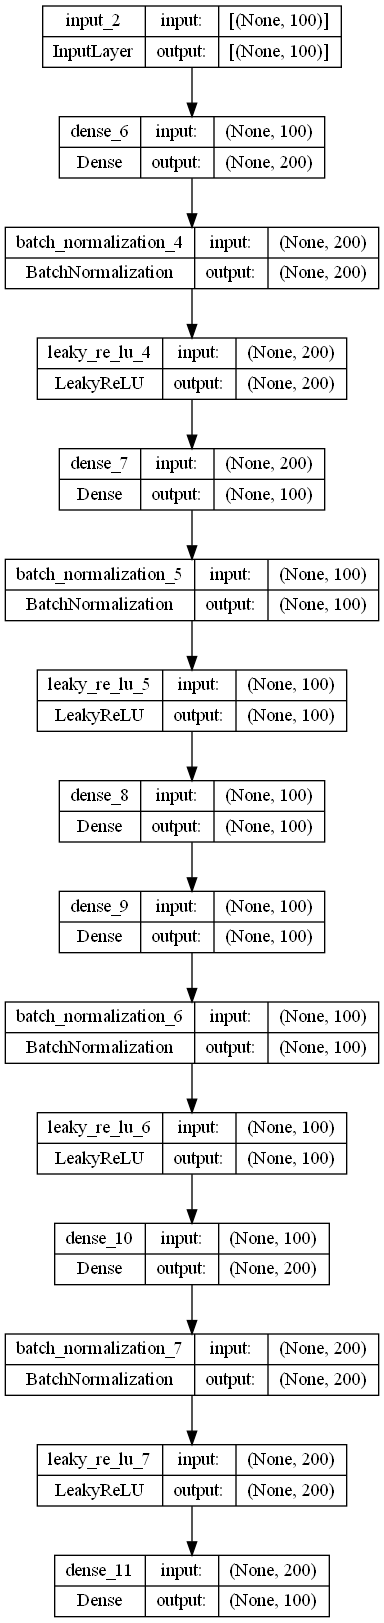

In [19]:
# plot the autoencoder
plot_model(model, 'Pics/autoencoder_no_compress.png', show_shapes=True)

Train the model to reproduce the input and keep track of the performance of the model on the hold-out test set.

In [20]:
history = model.fit(X_train, X_train, epochs=100, batch_size=16, verbose=2, validation_data=(X_test,X_test))

Epoch 1/100
42/42 - 2s - loss: 0.2352 - val_loss: 0.1853 - 2s/epoch - 42ms/step
Epoch 2/100
42/42 - 1s - loss: 0.0394 - val_loss: 0.1037 - 698ms/epoch - 17ms/step
Epoch 3/100
42/42 - 1s - loss: 0.0229 - val_loss: 0.0535 - 696ms/epoch - 17ms/step
Epoch 4/100
42/42 - 1s - loss: 0.0186 - val_loss: 0.0294 - 699ms/epoch - 17ms/step
Epoch 5/100
42/42 - 1s - loss: 0.0161 - val_loss: 0.0191 - 702ms/epoch - 17ms/step
Epoch 6/100
42/42 - 1s - loss: 0.0140 - val_loss: 0.0135 - 691ms/epoch - 16ms/step
Epoch 7/100
42/42 - 1s - loss: 0.0123 - val_loss: 0.0111 - 682ms/epoch - 16ms/step
Epoch 8/100
42/42 - 1s - loss: 0.0122 - val_loss: 0.0080 - 672ms/epoch - 16ms/step
Epoch 9/100
42/42 - 1s - loss: 0.0111 - val_loss: 0.0068 - 688ms/epoch - 16ms/step
Epoch 10/100
42/42 - 1s - loss: 0.0105 - val_loss: 0.0063 - 689ms/epoch - 16ms/step
Epoch 11/100
42/42 - 1s - loss: 0.0100 - val_loss: 0.0061 - 683ms/epoch - 16ms/step
Epoch 12/100
42/42 - 1s - loss: 0.0099 - val_loss: 0.0060 - 679ms/epoch - 16ms/step
Epoc

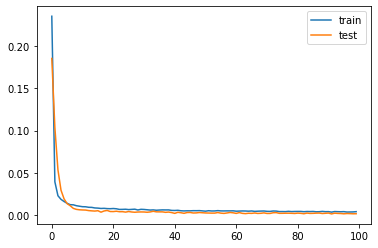

In [21]:
# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Save the encoder

In [26]:
# define an encoder model (without the decoder)
encoder = Model(inputs=visible, outputs=bottleneck)
plot_model(encoder, 'Pics/encoder_no_compress.png', show_shapes=True)
# save the encoder to file, NOTE: remember to compile encoder before saving
encoder.compile(optimizer='adam', loss='mse')
encoder.save('Models/006_encoder.h5')

Observation: from [here](https://machinelearningmastery.com/autoencoder-for-classification/), losses are similarly when we set with and without compression. The AE performs similarly with bottleneck_size = n_inputs and with bottleneck_size=(1/2)*n_inputs.

## c. Encoder as Data Preparation for Predictive Mode. How to use the saved Encoder

Use the trained encoder from the autoencoder to compress input data and train a different predictive model

S1. Train a logistic regression model using orginal data

In [28]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
# define dataset
X, y = make_classification(n_samples=1000, n_features=100, n_informative=10, n_redundant=90, random_state=1)
# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# scale data
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)
# define model
model = LogisticRegression()
# fit model on training set
model.fit(X_train, y_train)
# make prediction on test set
yhat = model.predict(X_test)
# calculate accuracy
acc = accuracy_score(y_test, yhat)
print(acc)

0.8939393939393939


S2. Train model using Encoder compressed data

In [30]:
# load the model from file
encoder = load_model('Models/006_encoder.h5', compile=False)
# encode the train and test data
X_train_encode = encoder.predict(X_train)
X_test_encode = encoder.predict(X_test)
# define the model
model = LogisticRegression()
# fit the model on the encoded training set
model.fit(X_train_encode, y_train)
# make predictions on the encoded test set
yhat = model.predict(X_test_encode)
# calculate classification accuracy
acc = accuracy_score(y_test, yhat)
print(acc)

11/11 [==============================] - 0s 2ms/step
0.9272727272727272


c:\Users\tranl\miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


This is a better classification accuracy than the same model evaluated on the raw dataset, suggesting that the encoding is helpful for our chosen model and test harness

# Reference
- [https://machinelearningmastery.com/autoencoder-for-classification/](https://machinelearningmastery.com/autoencoder-for-classification/)

***Others***

- [https://socr.umich.edu/HTML5/ABIDE_Autoencoder/](https://socr.umich.edu/HTML5/ABIDE_Autoencoder/)
- [https://www.thepythoncode.com/article/feature-extraction-dimensionality-reduction-autoencoders-python-keras](https://www.thepythoncode.com/article/feature-extraction-dimensionality-reduction-autoencoders-python-keras)
- [https://www.geeksforgeeks.org/ml-classifying-data-using-an-auto-encoder/](https://www.geeksforgeeks.org/ml-classifying-data-using-an-auto-encoder/)
- [dimensionality-reduction-using-an-autoencoder-in-python](https://medium.datadriveninvestor.com/dimensionality-reduction-using-an-autoencoder-in-python-bf540bb3f085)
- [https://deepnote.com/@maksim-denisov-c524/Autoencoder-OPTUNA-b8dff306-2a64-49fe-b1b0-347afb5c6954](https://deepnote.com/@maksim-denisov-c524/Autoencoder-OPTUNA-b8dff306-2a64-49fe-b1b0-347afb5c6954)